In [1]:
import numpy as np
import matplotlib.pyplot as plt
from photonpilot.fpc import LayeredDGF

# Test example of a Fabry Perot cavity

### Simple Fabry Perot with perfect mirrors
Note that with perfect mirrors and a vacuum cavity region there is no frequency dependence of the material constants and the problem therefore becomes scaleinvariant retaining only a dependence on $d/\lambda$. However, for simplicity we choose an emitter wavelength of 200 nm for this example.

In [2]:
## Constants
hbar = 1.05E-34 #6.582E-16
hbar_eVs = 6.582E-16
c = 3E8
e = 1.6E-19
epsilon0 = 8.9E-12
conversion_factor = (6.24E18)/1E18



In [3]:
# Desired energy range in eV
emin = 0.001
emax = 10
Nw = 100 # Number of frequency points

omegas = np.linspace(emin, emax, 100)/hbar_eVs
dw = np.abs(omegas[1] - omegas[0])

# Cavity setup
d = 450E-9 # Cavity width
t = d/2 # Distance from emitter position to the top mirror
b = d/2 # Distance from emitter position to the bottom mirror
eps_cav = 1 # Dielectric constant of the cavity region


# Reflection coefficients, here just using idealized mirrors
r12_s = -0.7
r13_s = -1

r12_p = 0.7
r13_p = 1


lambda_h = []
lambda_v = []

for w in omegas:
    k0 = np.sqrt(eps_cav)*(w/c)
    qs = np.linspace(0, 1.51, int(1E5), dtype = "complex128")*k0 # qs used for the numerical evaluation of the DGF (This quantity should be converged)

    DGF = LayeredDGF(qs, k0, r12_s, r13_s, r12_p, r13_p, d, b, t)
    DGF.get_all_DGF_components()
    
    l_hs = np.sqrt(2*e**2*w/(np.pi*epsilon0*c**2)*np.imag(DGF.G_zz_te_ip + DGF.G_zz_tm_ip))*np.sqrt(dw)
    l_vp = np.sqrt(2*e**2*w/(np.pi*epsilon0*c**2)*np.imag(DGF.G_zz_tm_op))*np.sqrt(dw)

    lambda_h.append(l_hs) 
    lambda_v.append(l_vp) 

# Converting from J/m² to to eV/m²
lambda_h = np.array(lambda_h)*conversion_factor
lambda_v = np.array(lambda_v)*conversion_factor

(0.0, 10.49995)

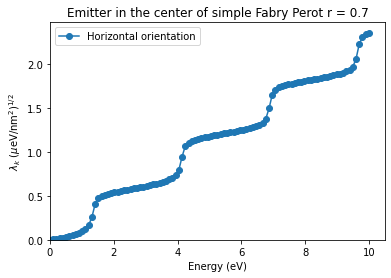

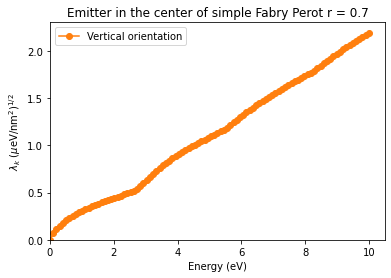

In [4]:
fig = plt.figure()
plt.plot(omegas*hbar_eVs, 1E3*np.array(lambda_h), '-o', label = "Horizontal orientation")
plt.title("Emitter in the center of simple Fabry Perot r = {}".format(-r12_s))
plt.xlabel("Energy (eV)")
plt.ylabel("$\lambda_k$ ($\mu$eV/nm$^2$)$^{1/2}$")
plt.legend()
plt.ylim(bottom = 0)
plt.xlim(left = 0)

fig = plt.figure()
plt.plot(omegas*hbar_eVs, 1E3*np.array(lambda_v), '-o', label = "Vertical orientation", color = "C1")
plt.title("Emitter in the center of simple Fabry Perot r = {}".format(-r12_s))
plt.xlabel("Energy (eV)")
plt.ylabel("$\lambda_k$ ($\mu$eV/nm$^2$)$^{1/2}$")
plt.legend()
plt.ylim(bottom = 0)
plt.xlim(left = 0)

## Example of mode packaging for octopus
Here we show an example of how to package the photon modes for use in the Octopus Casida code

In [5]:
Ns = [100]
for N in Ns:
    # Constants for conversion to octopus units
    eVPerAU = 27.211 #27.211 eV per Hartree
    nmPerBohr = 0.0529 # 0.0529 nm per Bohr

    # Frequencies in THz
    omega = np.linspace(emin, emax, int(N))*e/hbar

    numModes = 0
    outputArray = []

    lambda_h = []
    lambda_v = []
    for w in omega:
        # Setting up integration
        k0 = np.sqrt(eps_cav)*(w/c)
        qs = np.linspace(0, 1.51, int(1E4), dtype = "complex128")*k0

        # Calculating the DGF
        DGF = LayeredDGF(qs, k0, r12_s, r13_s, r12_p, r13_p, d, b, t)
        DGF.get_all_DGF_components()
        
        # Calculating lambda parameters for horizontal (l_h) and vertical (l_v) orientations
        l_h = np.sqrt(2*e**2*w/(np.pi*epsilon0*c**2)*np.imag(DGF.G_zz_te_ip + DGF.G_zz_tm_ip))*np.sqrt(dw)
        l_v = np.sqrt(2*e**2*w/(np.pi*epsilon0*c**2)*np.imag(DGF.G_zz_tm_op))*np.sqrt(dw)
        lambda_h.append(l_h*conversion_factor) 
        lambda_v.append(l_v*conversion_factor) 

        # Converting to octopus units
        l_hs = l_hs*nmPerBohr/np.sqrt(eVPerAU)
        w = w*(hbar/e)/eVPerAU

        # Adding modes to the output array
        outputArray.append([w,l_h,1,0,0])
        outputArray.append([w,l_h,0,1,0])
        outputArray.append([w,l_v,0,0,1])
        numModes = numModes + 3
    
    # Packaging the modes
    outputname = 'layered_modes_d={}nm_N_{}'.format(d*1E9, int(N))
    f = open(outputname, 'w')
    string = '{} 5\n'.format(numModes)
    f.write(string)
    for i in range(0,len(outputArray)):
        string = '%2.15f  %2.15f  %2.15f  %2.15f  %2.15f\n' % \
        (outputArray[i][0], outputArray[i][1], outputArray[i][2], outputArray[i][3], outputArray[i][4])
        f.write(string)
    f.close()


# Purcell enhancement
In many ways, the Purcell enhancement is easier to understand and we therefore provide an example of how it can be calculated for the layered cavity here. This also allows us to discuss some important aspects relating to convergence of the q-integrals. We show the Purcell enhancement as a function of mirror distance over emitter wavelength

In [6]:
## Setup
omega = 3*e/hbar # OBS angular frequency
lambda0 = 2*np.pi*c/(omega)

lambda0 = 1
k0 = eps_cav*2*np.pi/lambda0


In [7]:
N = 5E6

qs1 = np.linspace(0, 1-1/N, int(N/2), dtype = "complex128")*k0
qs2 = np.linspace(1-1/N, 2, int(N/2), dtype = "complex128")*k0
qs = np.concatenate((qs1, qs2))
# Reflection coefficients for the different polarizations
r12_s = -0.95
r13_s = -1

r12_p = 0.95
r13_p = 1

ds = np.linspace(0, 2, 100)*lambda0
rates_h_dgf = []
rates_v_dgf = []

rates_wb_h = []
rates_wb_v = []

for count, d in enumerate(ds):
    if count%20 == 0:
        print(count)
    # Placing the emitter in the center of the cavity
    t = d/2
    b = d/2
    # Getting the DGF 
    DGF = LayeredDGF(qs, k0, r12_s, r13_s, r12_p, r13_p, d, b, t)
    DGF.get_all_DGF_components()

    rate_h_dgf = 6*np.pi/k0*np.imag(DGF.G_zz_te_ip + DGF.G_zz_tm_ip)
    rate_v_dgf = 6*np.pi/k0*np.imag(DGF.G_zz_tm_op)

    rates_h_dgf.append(rate_h_dgf)
    rates_v_dgf.append(rate_v_dgf)

0
20
40
60
80


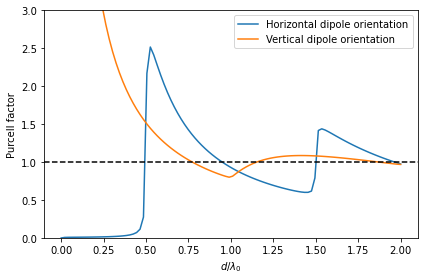

In [8]:
fig = plt.figure()
plt.plot(ds/lambda0, rates_h_dgf, label = "Horizontal dipole orientation")
plt.plot(ds/lambda0, rates_v_dgf, label = "Vertical dipole orientation")
plt.axhline(1, linestyle = "--", color = "k")
plt.ylabel('Purcell factor')
plt.xlabel('$d/\lambda_0$')
plt.ylim([0, 3])
plt.legend()
plt.tight_layout()

### Convergence with number of q-points
One of the most critical convergence parameters is the number of q-points used in the numerical integration needed to calculate the DGF. See below

0
0
0
0
0


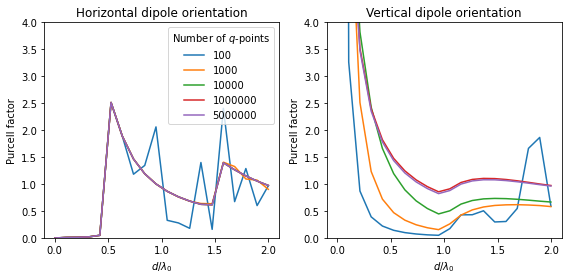

In [17]:
Ns = [1E2, 1E3, 1E4, 1E6, 5E6]

fig, ax = plt.subplots(1,2, figsize = (8,4))
for N in Ns:
    qs1 = np.linspace(0, 1-1/N, int(N/2), dtype = "complex128")*k0
    qs2 = np.linspace(1-1/N, 2, int(N/2), dtype = "complex128")*k0
    qs = np.concatenate((qs1, qs2))

    # Reflection coefficients for the different polarizations
    r12_s = -0.95
    r13_s = -1

    r12_p = 0.95
    r13_p = 1

    ds = np.linspace(0, 2, 20)*lambda0
    rates_h_dgf = []
    rates_v_dgf = []

    rates_wb_h = []
    rates_wb_v = []

    for count, d in enumerate(ds):
        if count%20 == 0:
            print(count)
        # Placing the emitter in the center of the cavity
        t = d/2
        b = d/2
        # Getting the DGF 
        DGF = LayeredDGF(qs, k0, r12_s, r13_s, r12_p, r13_p, d, b, t)
        DGF.get_all_DGF_components()

        rate_h_dgf = 6*np.pi/k0*np.imag(DGF.G_zz_te_ip + DGF.G_zz_tm_ip)
        rate_v_dgf = 6*np.pi/k0*np.imag(DGF.G_zz_tm_op)

        rates_h_dgf.append(rate_h_dgf)
        rates_v_dgf.append(rate_v_dgf)
    
    ax[0].plot(ds/lambda0, rates_h_dgf, label = int(N))
    ax[1].plot(ds/lambda0, rates_v_dgf)

ax[0].set_ylim([0, 4])
ax[1].set_ylim([0, 4])

ax[0].set_title('Horizontal dipole orientation')
ax[1].set_title('Vertical dipole orientation')

ax[0].set_ylabel('Purcell factor')
ax[1].set_ylabel('Purcell factor')

ax[0].set_xlabel('$d/\lambda_0$')
ax[1].set_xlabel('$d/\lambda_0$')

ax[0].legend(title = "Number of $q$-points")
fig.tight_layout()

### Fabry Perot cavity with Drude mirrors
Here we show the same but the slightly more realistic example of a Fabry Perot cavity with mirrors made from a Drude metal

##### Helper functions to calculate Fresnel coefficients

In [11]:
def r_te_ab(qs, omega, eps_a, eps_b):
    """
    Finds the fresnel coefficents of the a-b interface for TE-polarized light incident from a
    """
    # print(np.sqrt(eps_a))
    k_a0 = np.sqrt(eps_a)*(omega/c)
    k_b0 = np.sqrt(eps_b)*omega/c
    
    qs_a = np.sqrt(k_a0**2 - qs**2)
    qs_b = np.sqrt(k_b0**2 - qs**2)
    
    r_te = (qs_a - qs_b)/(qs_a + qs_b)
    return r_te

def r_tm_ab(qs, omega, eps_a, eps_b):
    """
    Finds the fresnel coefficents of the a-b interface for TM-polarized light incident from a
    """
    # print(np.sqrt(eps_a))
    k_a0 = np.sqrt(eps_a)*(omega/c)
    k_b0 = np.sqrt(eps_b)*omega/c
    
    
    qs_a = np.sqrt(k_a0**2 - qs**2)
    qs_b = np.sqrt(k_b0**2 - qs**2)
    
    r_tm = -(eps_a*qs_b - eps_b*qs_a)/(eps_b*qs_a + eps_a*qs_b)
    return r_tm

def epsilon_drude(omega, eps_inf, omega_p, gamma):
    """
    Drude dielectric constant of metal
    """
    return eps_inf - omega_p**2/(omega**2 + 1j*omega*gamma)

In [12]:
# Gold Drude paramters
eps_inf = 1
omega_p = 8*e/hbar
gamma = 0.69*e/hbar

eps_cav = 1
omega = 3*e/hbar # OBS angular frequency
lambda0 = 2*np.pi*c/(omega)
k0 = np.sqrt(eps_cav)*(omega/c)

In [13]:
eps_top = epsilon_drude(omega, eps_inf, omega_p, gamma)
eps_bottom = epsilon_drude(omega, eps_inf, omega_p, gamma)

N = int(1E6)
qs = np.linspace(0, 100, int(N), dtype = "complex128")*k0

r12_p = r_tm_ab(qs, omega, eps_cav, eps_top)
r13_p = r_tm_ab(qs, omega, eps_cav, eps_bottom)
r12_s = r_te_ab(qs, omega, eps_cav, eps_top)
r13_s = r_te_ab(qs, omega, eps_cav, eps_bottom)

ds = np.linspace(0, 2.5, 100)*lambda0
rates_h_dgf = []
rates_v_dgf = []

rates_wb_h = []
rates_wb_v = []

for count, d in enumerate(ds):
    if count%20 == 0:
        print(count)
    # Placing the emitter in the center of the cavity
    t = d/2
    b = d/2
    # Getting the DGF 
    DGF = LayeredDGF(qs, k0, r12_s, r13_s, r12_p, r13_p, d, b, t)
    DGF.get_all_DGF_components()

    rate_h_dgf = 6*np.pi/k0*np.imag(DGF.G_zz_te_ip + DGF.G_zz_tm_ip)
    rate_v_dgf = 6*np.pi/k0*np.imag(DGF.G_zz_tm_op)

    rates_h_dgf.append(rate_h_dgf)
    rates_v_dgf.append(rate_v_dgf)

0
20
40
60
80


No handles with labels found to put in legend.


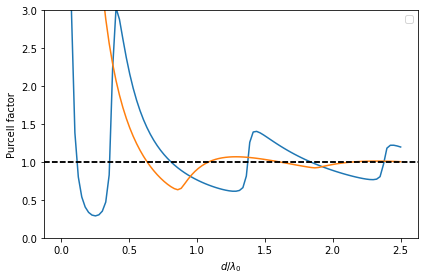

In [14]:
fig = plt.figure()
plt.plot(ds/lambda0, rates_h_dgf)
plt.plot(ds/lambda0, rates_v_dgf)
plt.axhline(1, linestyle = "--", color = "k")
plt.axhline(1, linestyle = "--", color = "k")
plt.ylabel('Purcell factor')
plt.xlabel('$d/\lambda_0$')
plt.ylim([0, 3])
plt.legend()
plt.tight_layout()

##### Converging the q-range 
Unlike the idealized mirror case, the mirrors in the Fabry Perot cavity can host evanescent modes with in-plane wave numbers larger than the free space wave number of light. It is therefore critical to converge the extended of the q-range used. 

0
0
0
0
0


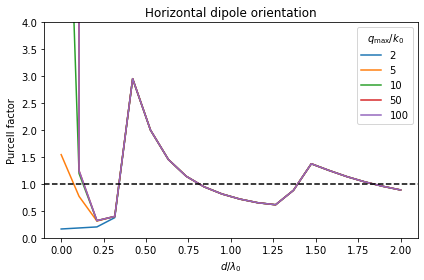

In [16]:
Ns = [2,5,10, 50, 100]

fig, ax = plt.subplots()
for N in Ns:
    qs = np.linspace(0, N, int(1E6), dtype = "complex128")*k0

    # Reflection coefficients for the different polarizations
    r12_p = r_tm_ab(qs, omega, eps_cav, eps_top)
    r13_p = r_tm_ab(qs, omega, eps_cav, eps_bottom)
    r12_s = r_te_ab(qs, omega, eps_cav, eps_top)
    r13_s = r_te_ab(qs, omega, eps_cav, eps_bottom)

    ds = np.linspace(0, 2, 20)*lambda0
    rates_h_dgf = []
    rates_v_dgf = []

    rates_wb_h = []
    rates_wb_v = []

    for count, d in enumerate(ds):
        if count%20 == 0:
            print(count)
        # Placing the emitter in the center of the cavity
        t = d/2
        b = d/2
        # Getting the DGF 
        DGF = LayeredDGF(qs, k0, r12_s, r13_s, r12_p, r13_p, d, b, t)
        DGF.get_all_DGF_components()

        rate_h_dgf = 6*np.pi/k0*np.imag(DGF.G_zz_te_ip + DGF.G_zz_tm_ip)
        rate_v_dgf = 6*np.pi/k0*np.imag(DGF.G_zz_tm_op)

        rates_h_dgf.append(rate_h_dgf)
        rates_v_dgf.append(rate_v_dgf)
    
    ax.plot(ds/lambda0, rates_h_dgf, label = N)

ax.legend(title = '$q_\mathrm{max}/k_0$')
ax.axhline(1, linestyle = "--", color = "k")
ax.set_ylim([0, 4])

ax.set_title('Horizontal dipole orientation')

ax.set_ylabel('Purcell factor')
ax.set_xlabel('$d/\lambda_0$')
fig.tight_layout()